In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import geopandas
import matplotlib

In [2]:
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

In [3]:
os.getcwd()

'/Users/alvastrand/Documents/OU/Research/notebooks/calculate_arrival_date'

In [4]:
path = '/Users/alvastrand/'
os.chdir(path)

In [5]:
os.getcwd()

'/Users/alvastrand'

In [6]:
filename = 'ebd_US_barswa_201001_202001_mad_relJan-2020_v2.csv'
df = pd.read_csv(filename)

In [7]:
df['mad'] = pd.to_datetime(df['mad'])

In [8]:
filename = 'ebd_US_barswa_201001_202001_relJan-2020_grid_cell_ids_v2.csv'
df_grid_cells = pd.read_csv(filename)

In [9]:
filename = 'ebd_US_barswa_201001_202001_first_of_season_relJan-2020_v2.csv'
df_first_of = pd.read_csv(filename)

In [10]:
df_first_of.rename(columns={'t_mad': 'first_of_season_arrival_day', 'mad': 'first_of_season_arrival_date'}, 
                   inplace=True)

In [11]:
df_first_of['first_of_season_arrival_date'] = pd.to_datetime(df_first_of['first_of_season_arrival_date'])

In [12]:
print(len(df))
# 809
print(len(df_grid_cells))
print(len(df_first_of))

809
182
800


In [13]:
print(len(df['grid_cell'].unique()))
# 88
print(len(df_first_of['grid_cell'].unique()))

88
87


In [14]:
df.head(2)

,grid_cell,year,nb_prop,r_squared,t_mad,mad,ci_nb_days
0,5,2010,19,0.118339,77.548667,2010-03-19,58.094665
1,5,2011,21,0.099887,43.949711,2011-02-13,36.750439


In [15]:
df_grid_cells.head(2)

,grid_cell,min_lat,max_lat,min_lon,max_lon
0,0,23,25,-93,-91
1,1,23,25,-91,-89


In [16]:
df_first_of.head(2)

,grid_cell,year,nb_prop,first_of_season_arrival_day,first_of_season_arrival_date
0,5,2010,19,95.0,2010-04-05
1,5,2013,52,62.0,2013-03-03


In [17]:
df_comp = df.merge(df_first_of, on=['grid_cell', 'year', 'nb_prop'])

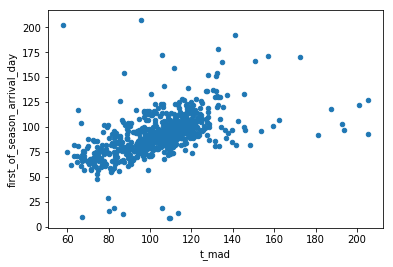

In [18]:
df_comp.plot('t_mad', 'first_of_season_arrival_day', kind='scatter')
plt.show()

Slope?
Residuals?

In [19]:
print(df['r_squared'].mean())
print(df['r_squared'].std())

print(df['r_squared'].median())

print(df['r_squared'].min())
print(df['r_squared'].max())

print(df['r_squared'].mean() + df['r_squared'].std())

0.5302622303005742
0.2742633062230601
0.5524047132972878
0.021784567950515418
0.9582594336809478
0.8045255365236343


In [20]:
def function_name(df, arrival_day_field_name, *args):
    
    if arrival_day_field_name == 't_mad':
        r_squared = args[0]
        print(r_squared)
        df = df[df['r_squared'] >= r_squared]
        print(len(df))
        print(len(df['grid_cell'].unique()))

    df_cnt = df[['grid_cell', 'year']].groupby(['grid_cell']).count()
    df_cnt.reset_index(inplace=True)
    df_cnt.rename(columns={'year': 'nb_years'}, inplace=True)

    print(len(df_cnt))

#     print(df_cnt.head(2))

    list_grid_cells = list(df_cnt[df_cnt['nb_years'] >= 5]['grid_cell'])
    print(len(list_grid_cells))

    df = df[df['grid_cell'].isin(list_grid_cells)] #

    print(len(df))

    list_means_days = []
    list_std_days = []
    list_days = []
    list_days_excluded = []
    list_slopes = []
    list_intercepts = []
    list_r_values = []
    list_p_values = []
    list_std_err = []

    for i in range(len(list_grid_cells)):
        df_subset = df[df['grid_cell'] == list_grid_cells[i]]
        linregress = scipy.stats.linregress(df_subset['year'], df_subset[arrival_day_field_name])
        mean_day = df_subset[arrival_day_field_name].mean()
        list_means_days.append(mean_day)
        std_day = df_subset[arrival_day_field_name].std()
        list_std_days.append(std_day)
        df_subset['day_excluded'] = np.where((df_subset[arrival_day_field_name] > mean_day + 2*std_day) | 
                                             (df_subset[arrival_day_field_name] < mean_day - 2*std_day), 1, 0)
        list_days.append(df_subset[[arrival_day_field_name, 'day_excluded']])
        if 1 in list(df_subset['day_excluded']):
            list_days_excluded.append(1)
        else:
            list_days_excluded.append(0)
        list_slopes.append(linregress[0])
        list_intercepts.append(linregress[1])
        list_r_values.append(linregress[2])
        list_p_values.append(linregress[3])
        list_std_err.append(linregress[4])
    #     plt.figure(figsize=(12.0, 4.0))
    #     plt.scatter(df_subset['year'], df_subset[arrival_day_field_name])
    #     plt.show()

    df_r = pd.DataFrame(data={'grid_cell': list_grid_cells, 'slope': list_slopes, 'intercept': list_intercepts, 
                              'r_value': list_r_values, 'p_value': list_p_values, 'std_err': list_std_err, 
                              'mean_day': list_means_days, 'std_day': list_std_days, 
                              'day_excluded': list_days_excluded})

    df_r = df_r.merge(df_grid_cells, on='grid_cell')

    print(len(df_r))

    df_r = df_r[df_r['day_excluded'] == 0]

    print(len(df_r))

    df['lat_band'] = np.nan

    list_lat_band_boundaries = range(20, 55, 5)

    for i in range(len(list_lat_band_boundaries)):
        if i == len(list_lat_band_boundaries) - 1:
            bounding_lat = list_lat_band_boundaries[i] + 5
        else:
            bounding_lat = list_lat_band_boundaries[i+1]
        df_r.loc[(df_r['min_lat'] > list_lat_band_boundaries[i]) & 
             (df_r['min_lat'] <= bounding_lat), 'lat_band'] = bounding_lat

    df_r['lat_band'] = df_r['lat_band'].astype(int)

#     print(df_r.head(2))

    list_lat_bands = list(df_r['lat_band'].unique())

    for i in range(len(list_lat_bands)):
        print(list_lat_bands[i])
        df_subset = df_r[df_r['lat_band'] == list_lat_bands[i]]
        print(df_subset['slope'].mean())
        print(df_subset['slope'].median())
    #     print(df_subset['slope'].std())

    print(scipy.stats.linregress(df_r['min_lat'], df_r['slope']))
    print(scipy.stats.linregress(df_r['max_lat'], df_r['slope']))
    print(scipy.stats.linregress(df_r['min_lon'], df_r['slope']))
    print(scipy.stats.linregress(df_r['max_lon'], df_r['slope']))

    plt.scatter(df_r['min_lat'], df_r['slope'])
    plt.show()

    plt.scatter(df_r['max_lat'], df_r['slope'])
    plt.show()

    plt.scatter(df_r['min_lon'], df_r['slope'])
    plt.show()

    plt.scatter(df_r['max_lon'], df_r['slope'])
    plt.show()

#     print(df.head(2))

#     print(df_r.head(2))

    print(len(df_r['grid_cell'].unique()))

    df_days_year = df[['grid_cell', 'year', arrival_day_field_name]].merge(df_r, on=['grid_cell'])

#     print(df_days_year.head(2))

    plt.scatter(df_days_year['year'], df_days_year[arrival_day_field_name])
    plt.xlabel('Year')
    plt.show()

    print(scipy.stats.linregress(df_days_year['year'], df_days_year[arrival_day_field_name]))

#     print(df_r.head(2))

    df_r['mean_lat'] = (df_r['min_lat'] + df_r['max_lat'])/2
    df_r['mean_lon'] = (df_r['min_lon'] + df_r['max_lon'])/2

    df_r['abs_slope'] = df_r['slope'].abs()*100

#     print(df_r.head(2))

    df_g = geopandas.GeoDataFrame(df_r, geometry=geopandas.points_from_xy(df_r['mean_lon'], df_r['mean_lat']))

#     print(df_g.head(2))

    print(df_g['slope'].min())
    print(np.floor(df_g['slope'].min()))
    print(df_g['slope'].max())
    print(np.ceil(df_g['slope'].max()))
    
    abs_floor_min_slope = np.absolute(np.floor(df_g['slope'].min()))
    abs_ceil_max_slope = np.absolute(np.ceil(df_g['slope'].max()))
    
    print(abs_floor_min_slope)
    print(abs_ceil_max_slope)
    
    greatest_abs = max([abs_floor_min_slope, abs_ceil_max_slope])
    
#     v_min = -greatest_abs
#     v_max = greatest_abs
    
    v_min = -4
    v_max = 4

    norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)

    matplotlib.rcParams['font.size'] = 15

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

    ax = world[world['iso_a3'] == 'USA'].plot(
        color='white', edgecolor='black', figsize=(20.0, 15.0))

    sc = plt.scatter('mean_lon', 'mean_lat', s=250, c='slope', alpha=0.5, cmap='RdBu_r', data=df_g, norm=norm, 
                     edgecolor='black', marker='o')
    # sc = plt.scatter('mean_lon', 'mean_lat', s='abs_slope', c='slope', alpha=0.5, cmap='RdBu', data=df_g)
    # plt.colorbar(sc, cax=ax)
    plt.colorbar(sc, fraction=0.0241, pad=0.015)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Slopes of mean arrival date as a function of time shown as bubbles on a map of the United States')
    plt.show()

    # world[world['iso_a3'] == 'USA']
    
    return df_r

87
81
780


/Users/alvastrand/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


81
43
25
-4.975757575757576
-4.975757575757576
30
-1.6486215538847118
-1.3458646616541354
35
-2.013174603174603
-1.8000000000000003
40
-1.4303030303030304
-0.8606060606060607
45
-0.11374393017395044
-0.41212121212121217
LinregressResult(slope=0.19634636911716863, intercept=-8.558082258627417, rvalue=0.5657343678541049, pvalue=7.702262653362473e-05, stderr=0.0446946104312411)
LinregressResult(slope=0.19634636911716863, intercept=-8.950774996861755, rvalue=0.5657343678541049, pvalue=7.702262653362473e-05, stderr=0.0446946104312411)
LinregressResult(slope=0.0900020233727524, intercept=6.239693447976097, rvalue=0.2703737873091931, pvalue=0.07950950754415069, stderr=0.05005088214248308)
LinregressResult(slope=0.0900020233727524, intercept=6.059689401230592, rvalue=0.2703737873091931, pvalue=0.07950950754415069, stderr=0.05005088214248308)


/Users/alvastrand/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


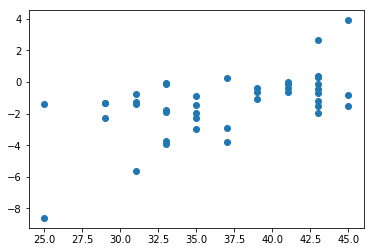

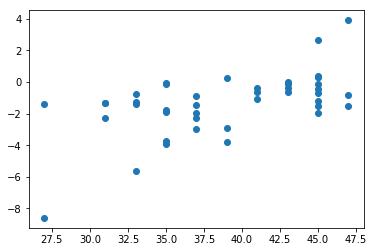

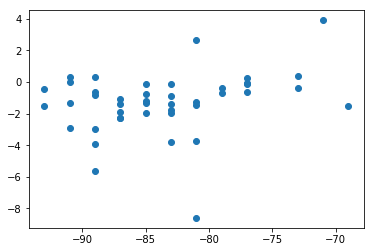

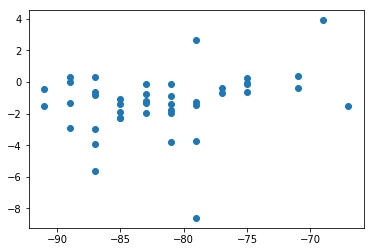

43


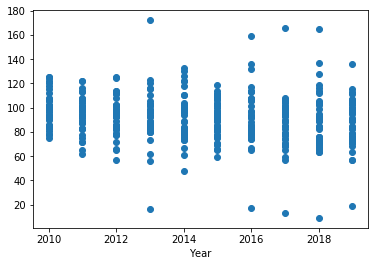

LinregressResult(slope=-1.1049798437742984, intercept=2317.677676830509, rvalue=-0.1601201107027742, pvalue=0.0011732366006210017, stderr=0.33806913808878664)
-8.581818181818182
-9.0
3.8857142857142857
4.0
9.0
4.0


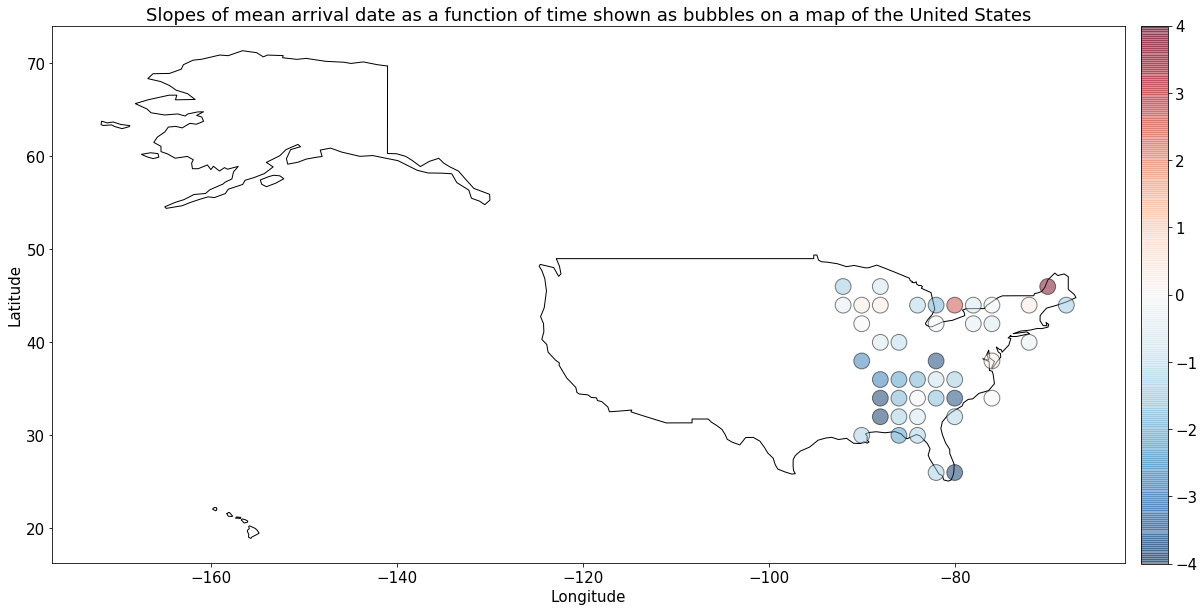

In [21]:
arrival_day_field_name = 'first_of_season_arrival_day'
df_r_first_of = function_name(df_first_of, arrival_day_field_name)

In [22]:
df_r_first_of.head(2)

,grid_cell,slope,intercept,r_value,p_value,std_err,mean_day,std_day,day_excluded,min_lat,max_lat,min_lon,max_lon,lat_band,mean_lat,mean_lon,abs_slope,geometry
1,19,-1.369697,2830.054545,-0.616218,0.057807,0.618924,70.8,6.729702,0,25,27,-83,-81,25,26.0,-82.0,136.969697,POINT (-82.00000 26.00000)
2,20,-8.581818,17332.272727,-0.797903,0.005673,2.292171,44.2,32.563784,0,25,27,-81,-79,25,26.0,-80.0,858.181818,POINT (-80.00000 26.00000)


0.1
762
85
85
78
744


/Users/alvastrand/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


78
44
25
-0.6204994960090333
-0.6204994960090333
30
0.2266534966649721
0.27958000264752764
35
0.9460217814715832
0.9540699636499833
40
0.20811196172838994
0.021690115399791345
45
0.19284053665737766
-0.16137889706413983
LinregressResult(slope=-0.00938289979830564, intercept=0.6982973687064418, rvalue=-0.0628611517614234, pvalue=0.6852047810748765, stderr=0.02298636702223487)
LinregressResult(slope=-0.00938289979830564, intercept=0.7170631683030531, rvalue=-0.0628611517614234, pvalue=0.6852047810748765, stderr=0.02298636702223487)
LinregressResult(slope=-0.026252121423636234, intercept=-1.8216571945808222, rvalue=-0.17438985307476162, pvalue=0.25756226353101913, stderr=0.022872424536868573)
LinregressResult(slope=-0.026252121423636234, intercept=-1.7691529517335498, rvalue=-0.17438985307476162, pvalue=0.25756226353101913, stderr=0.022872424536868573)


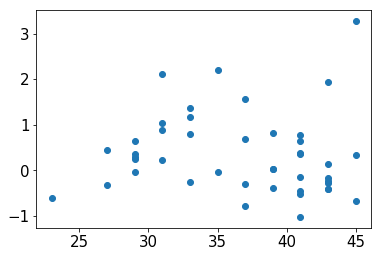

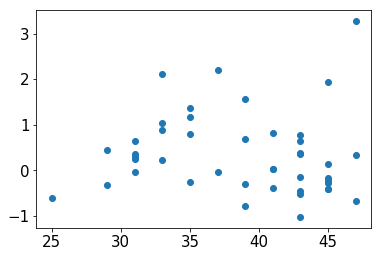

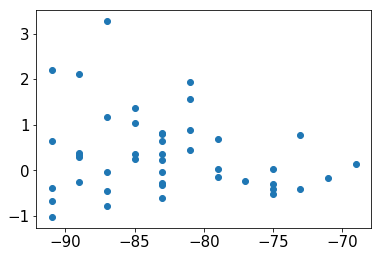

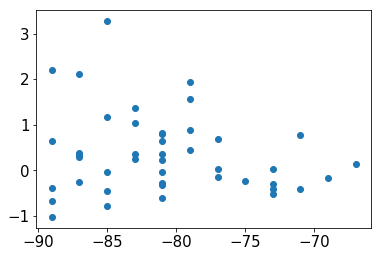

44


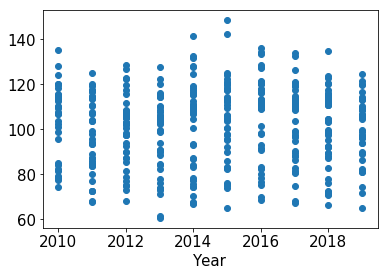

LinregressResult(slope=0.2725099753222891, intercept=-447.196617928365, rvalue=0.04499488591140155, pvalue=0.36171886085898486, stderr=0.29844085097243206)
-1.0348394109769914
-2.0
3.2786388863493174
4.0
2.0
4.0


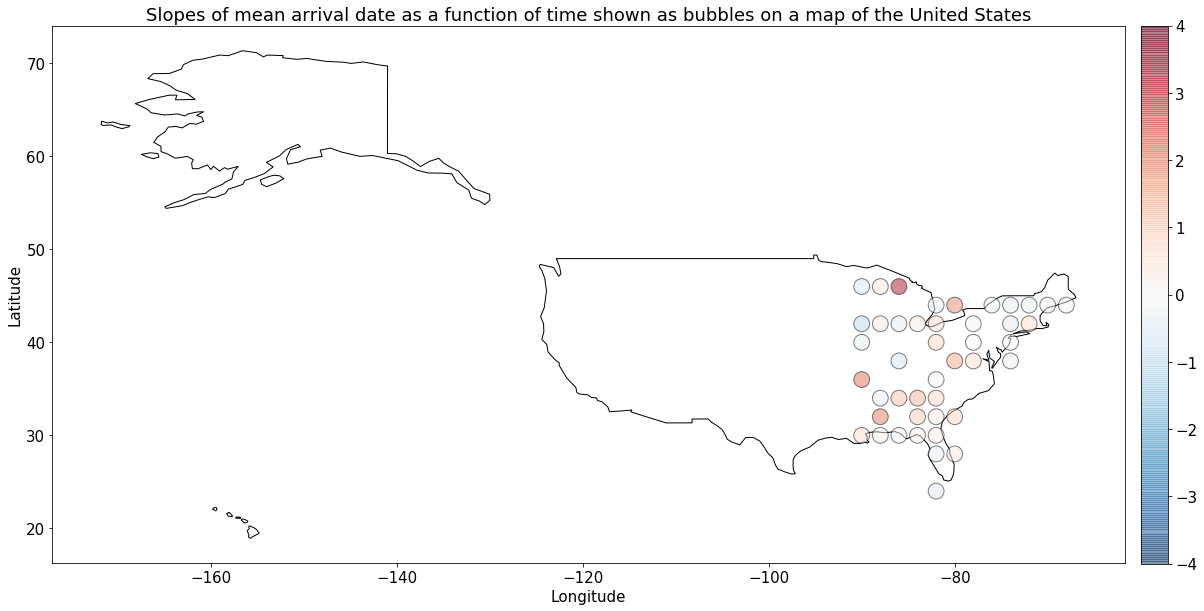

In [23]:
arrival_day_field_name = 't_mad'
r_squared = 0.1
df_r_mean = function_name(df, arrival_day_field_name, r_squared)

In [24]:
df_r_first_of.rename(columns={'slope': 'slope_first_of_season'}, inplace=True)
df_r_mean.rename(columns={'slope': 'slope_mean'}, inplace=True)

In [25]:
df_r_comp = df_r_first_of[['grid_cell', 'slope_first_of_season']].merge(df_r_mean[['grid_cell', 'slope_mean']], 
                                                                        on=['grid_cell'])

In [26]:
print(len(df_r_first_of))
print(len(df_r_mean))
print(len(df_r_comp))

43
44
20


In [27]:
df_r_comp.head(2)

,grid_cell,slope_first_of_season,slope_mean
0,43,-1.345865,0.637986
1,45,-2.266667,-0.049436


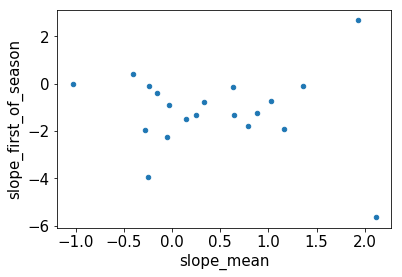

In [28]:
df_r_comp.plot('slope_mean', 'slope_first_of_season', kind='scatter')
plt.show()

0.5302622303005742
420
62
62
44
373
44
32
35

/Users/alvastrand/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.4568333133823237
0.5314248919779332
40
-0.38573225414030465
0.019736858697858614
45
0.022347638716629224
0.02608737961465609
LinregressResult(slope=-0.02679919027998602, intercept=1.0189324390146353, rvalue=-0.08496894702506347, pvalue=0.6438150740401221, stderr=0.05737561837014849)
LinregressResult(slope=-0.02679919027998602, intercept=1.0725308195746075, rvalue=-0.08496894702506347, pvalue=0.6438150740401221, stderr=0.05737561837014849)
LinregressResult(slope=0.03946535251221586, intercept=3.196006731157785, rvalue=0.22059523242867657, pvalue=0.22503736197729726, stderr=0.03185859364633388)
LinregressResult(slope=0.03946535251221586, intercept=3.1170760261333537, rvalue=0.22059523242867657, pvalue=0.22503736197729726, stderr=0.03185859364633388)


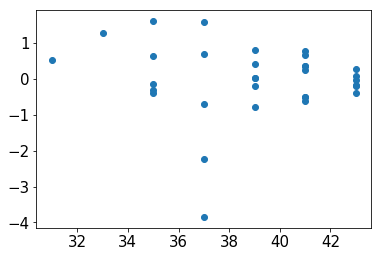

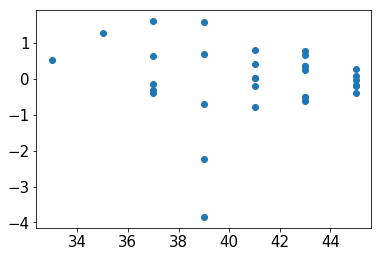

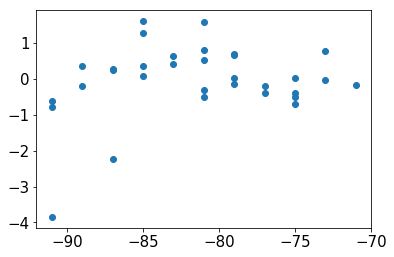

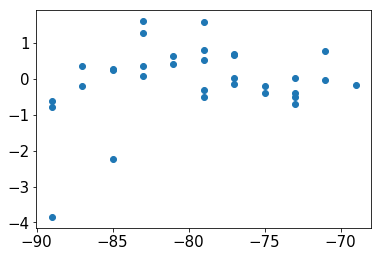

32


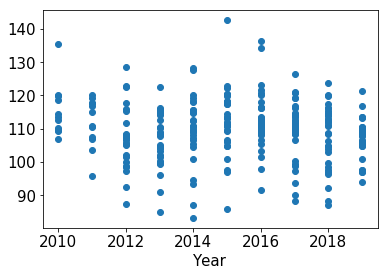

LinregressResult(slope=-0.2786169584859902, intercept=671.0923969305975, rvalue=-0.07930984751076856, pvalue=0.2024226104182341, stderr=0.21802203947205567)
-3.860793524633101
-4.0
1.6181445282337816
2.0
4.0
2.0


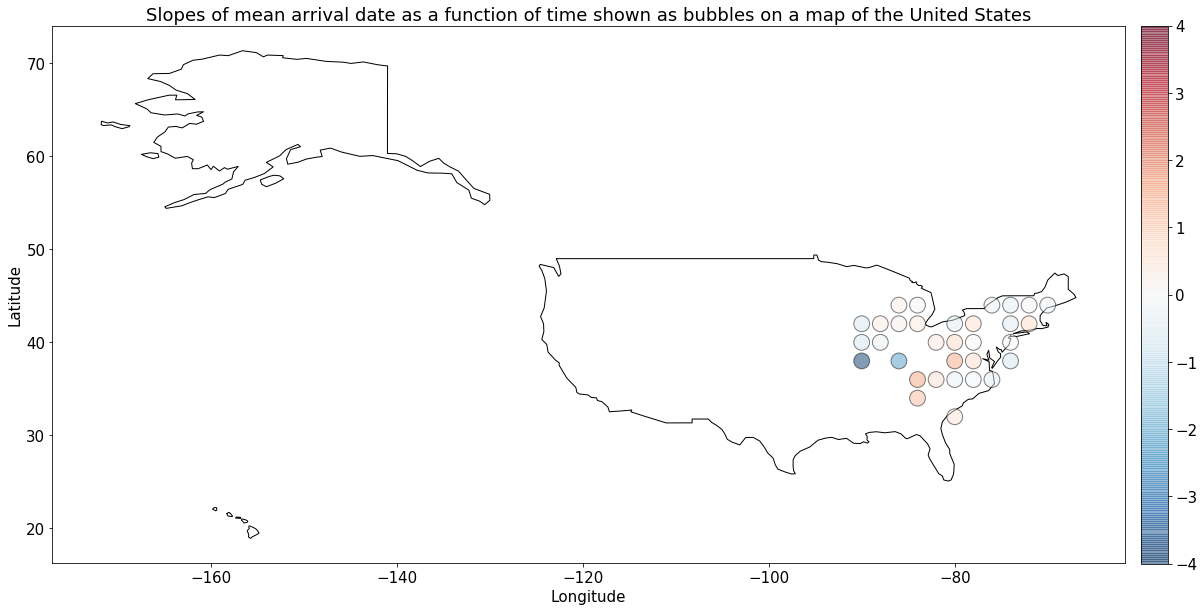

In [29]:
r_squared = df['r_squared'].mean()
df_r_mean = function_name(df, arrival_day_field_name, r_squared)

43
32
12


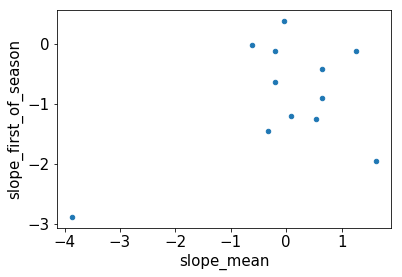

In [30]:
df_r_mean.rename(columns={'slope': 'slope_mean'}, inplace=True)

df_r_comp = df_r_first_of[['grid_cell', 'slope_first_of_season']].merge(df_r_mean[['grid_cell', 'slope_mean']], 
                                                                        on=['grid_cell'])

print(len(df_r_first_of))
print(len(df_r_mean))
print(len(df_r_comp))

df_r_comp.plot('slope_mean', 'slope_first_of_season', kind='scatter')
plt.show()

0.8045255365236343
169
35
35
18
127
18
15
40
-0.6630254368393743
-0.40539720503267873
45
-1.1296030718284322
-0.28552524477504
LinregressResult(slope=-0.4425264840856066, intercept=16.964599704831404, rvalue=-0.4205723719588631, pvalue=0.11852570316920924, stderr=0.2647635117918411)
LinregressResult(slope=-0.4425264840856066, intercept=17.84965267300262, rvalue=-0.4205723719588631, pvalue=0.11852570316920924, stderr=0.2647635117918411)
LinregressResult(slope=-0.07166382968561959, intercept=-6.671300804036669, rvalue=-0.23820179282460913, pvalue=0.39259436281353266, stderr=0.08103991900884623)
LinregressResult(slope=-0.07166382968561959, intercept=-6.527973144665429, rvalue=-0.23820179282460913, pvalue=0.39259436281353266, stderr=0.08103991900884623)


/Users/alvastrand/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


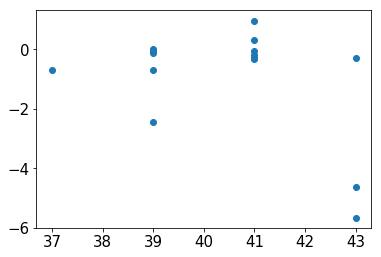

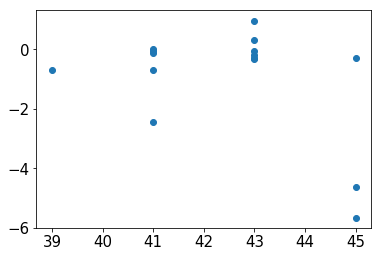

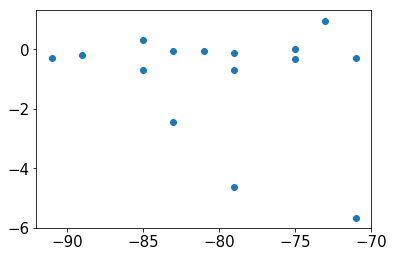

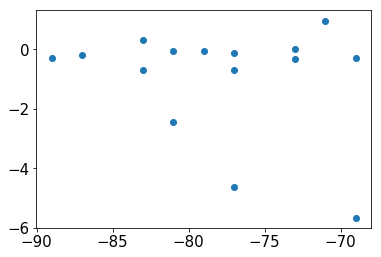

15


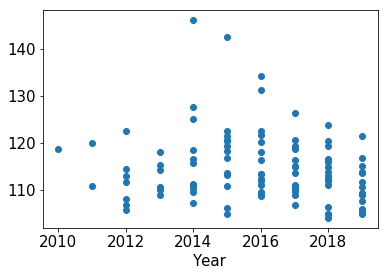

LinregressResult(slope=-0.5327774237227263, intercept=1188.5558046323906, rvalue=-0.16400828547494875, pvalue=0.1029907591160969, stderr=0.32370246715609724)
-5.653314032291608
-6.0
0.9667873812737589
1.0
6.0
1.0


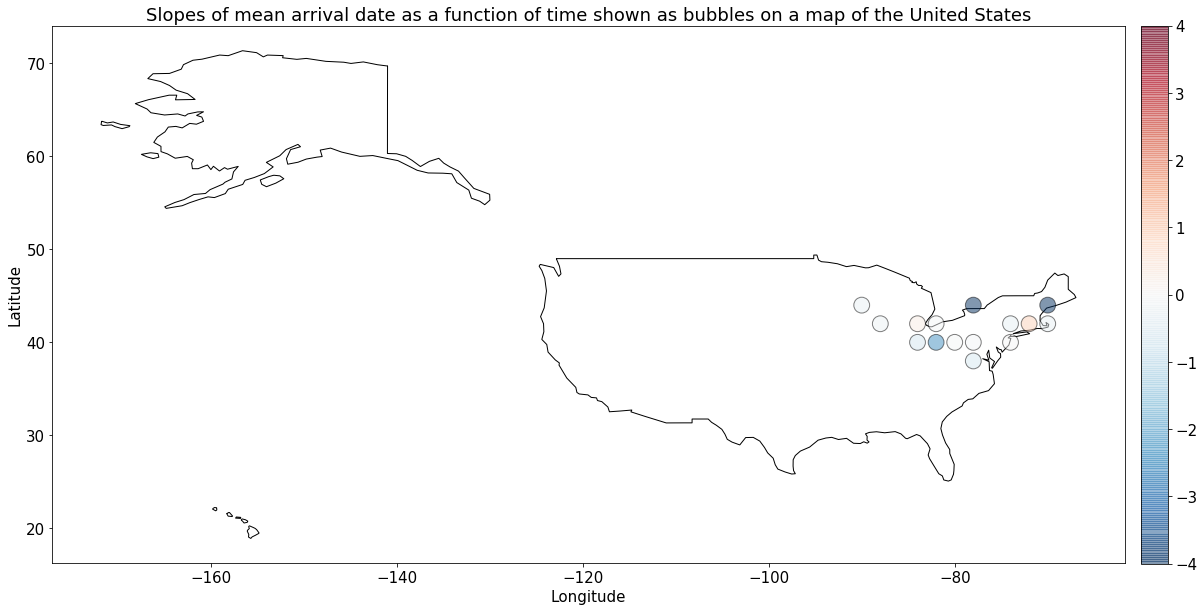

In [31]:
r_squared = df['r_squared'].mean() + df['r_squared'].std()
df_r_mean = function_name(df, arrival_day_field_name, r_squared)

43
15
3


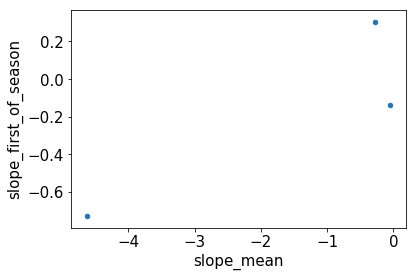

In [32]:
df_r_mean.rename(columns={'slope': 'slope_mean'}, inplace=True)

df_r_comp = df_r_first_of[['grid_cell', 'slope_first_of_season']].merge(df_r_mean[['grid_cell', 'slope_mean']], 
                                                                        on=['grid_cell'])

print(len(df_r_first_of))
print(len(df_r_mean))
print(len(df_r_comp))

df_r_comp.plot('slope_mean', 'slope_first_of_season', kind='scatter')
plt.show()